In [18]:
import sys
sys.path.insert(0, '../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs


np.random.seed(1234)
tf.set_random_seed(1234)

In [19]:
# u=f(x,t,a,b,c,d)


# (x,t)
# a1 = w1*x+w2*t+b
# a2 = w1*x+w2*t+b
# u = w*a+b

# du/dx
# du/dt

# min (dt/dt-0.2*df/dx*df/dx)
# (x,t)->DNN->u



In [20]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.nu = nu
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)         
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x,t):
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        #f = u_t + u*u_x - self.nu*u_xx
        #f = u_t - 0.2*u_xx
        #f = u_t - u_x #1D wave propagating left
        #f = u_t - u_x - 0.1*u_xx #1D wave propagation and diffusion
        f = u_t - (0.2+u)*u_x - self.nu*u_xx #1D burger problem with diffusion
        #f = u_t*u_t - u_x*u_x #1D wave propagating left
        return f
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self):
        
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return u_star, f_star

## Training Neural Net with Initial & Boundary Condition and Physics Laws

In [21]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 1000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('../appendix/Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #initial condition
#uu1 = Exact[0:1,:].T
#uu1 = np.exp(-100*xx1[:,0:1]*xx1[:,0:1])
uu1 = np.exp(-10*xx1[:,0:1]*xx1[:,0:1])*np.sin(xx1[:,0:1]*np.pi)
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #boundary condition at x = -1
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #boundary condition at x = 1
uu3 = Exact[:,-1:]

#X_u_train = np.vstack([xx1, xx2, xx3])
#u_train = np.vstack([uu1, uu2, uu3])
X_u_train = np.vstack([xx1])
u_train = np.vstack([uu1])

In [22]:
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))


In [23]:
# select partial region to reinforce physics.
#X_f_train = np.array([X_f_train[i] for i in range(X_f_train.shape[0]) if (X_f_train[i,1]<0.2) or ((X_f_train[i,1]>0.5) and (X_f_train[i,1]<0.6)) or (abs(X_f_train[i,0])<0.2 and (X_f_train[i,1]<0.8))])
#X_f_train = np.array([X_f_train[i] for i in range(X_f_train.shape[0]) if (X_f_train[i,1]<0.2) or ((X_f_train[i,1]>0.7) and (X_f_train[i,1]<0.9))])

In [24]:
#idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
#X_u_train = X_u_train[idx, :]
#u_train = u_train[idx,:]

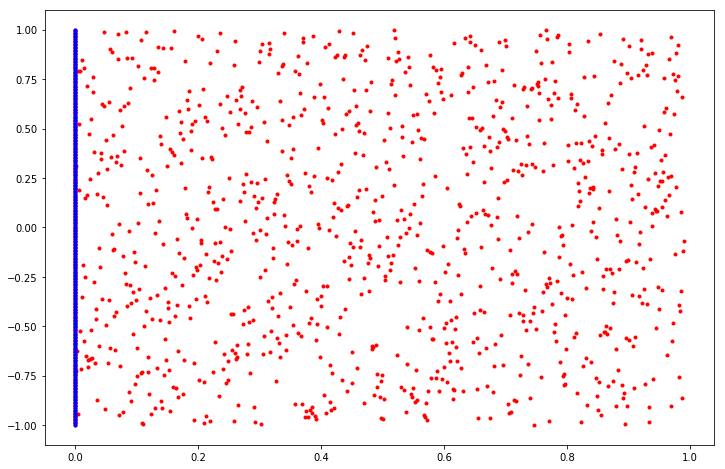

In [25]:
plt.figure(figsize=(12,8))
plt.plot(X_f_train[:,1],X_f_train[:,0],'r.')
plt.plot(X_u_train[:,1],X_u_train[:,0],'b.')


In [26]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

In [27]:
start_time = time.time()                
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Loss: 0.046536203
Loss: 2.6216745
Loss: 0.042967137
Loss: 0.041606776
Loss: 0.03580743
Loss: 0.034806315
Loss: 0.03473272
Loss: 0.034706563
Loss: 0.03470493
Loss: 0.03469334
Loss: 0.034617983
Loss: 0.034535833
Loss: 0.03440618
Loss: 0.034244567
Loss: 0.03409524
Loss: 0.034162305
Loss: 0.03391258
Loss: 0.03363425
Loss: 0.033008777
Loss: 0.0324436
Loss: 0.03274565
Loss: 0.031515658
Loss: 0.03155169
Loss: 0.030432168
Loss: 0.027467746
Loss: 0.025887739
Loss: 0.02563403
Loss: 0.024178276
Loss: 0.023561485
Loss: 0.019305302
Loss: 0.01634486
Loss: 0.020010274
Loss: 0.014461994
Loss: 0.01448882
Loss: 0.012705719
Loss: 0.012058739
Loss: 0.0117690265
Loss: 0.01150766
Loss: 0.011120116
Loss: 0.010068642
Loss: 0.009666389
Loss: 0.009355584
Loss: 0.009290636
Loss: 0.009279774
Loss: 0.009273332
Loss: 0.009262386
Loss: 0.009215772
Loss: 0.009164927
Loss: 0.009091465
Loss: 0.009003953
Loss: 0.008922061
Loss: 0.008872113
Loss: 0.008780982
Loss: 0.008643606
Loss: 0.008450452
Loss: 0.0083860345
Loss: 0.

Loss: 4.351917e-05
Loss: 4.3266977e-05
Loss: 4.2904227e-05
Loss: 4.2546606e-05
Loss: 4.215137e-05
Loss: 4.1989584e-05
Loss: 4.2624506e-05
Loss: 4.1802756e-05
Loss: 4.1271986e-05
Loss: 4.0711104e-05
Loss: 4.0065566e-05
Loss: 3.9206276e-05
Loss: 3.825982e-05
Loss: 3.7856113e-05
Loss: 3.742805e-05
Loss: 3.707181e-05
Loss: 3.6545123e-05
Loss: 3.664631e-05
Loss: 3.630996e-05
Loss: 3.605259e-05
Loss: 3.582004e-05
Loss: 3.5568784e-05
Loss: 3.539752e-05
Loss: 3.5232286e-05
Loss: 3.5102606e-05
Loss: 3.494966e-05
Loss: 3.465269e-05
Loss: 3.4295266e-05
Loss: 3.3792527e-05
Loss: 3.346704e-05
Loss: 3.3146323e-05
Loss: 3.2991855e-05
Loss: 3.289857e-05
Loss: 3.2771946e-05
Loss: 3.2687512e-05
Loss: 3.257704e-05
Loss: 3.2444983e-05
Loss: 3.2264372e-05
Loss: 3.2101034e-05
Loss: 3.2132568e-05
Loss: 3.194888e-05
Loss: 3.1809304e-05
Loss: 3.1518593e-05
Loss: 3.120769e-05
Loss: 3.08177e-05
Loss: 3.0156214e-05
Loss: 3.1694606e-05
Loss: 2.9869487e-05
Loss: 2.9177452e-05
Loss: 2.8690956e-05
Loss: 2.8442175e-05

Loss: 4.0343125e-06
Loss: 4.0252858e-06
Loss: 4.0121413e-06
Loss: 4.0255086e-06
Loss: 4.007397e-06
Loss: 3.996044e-06
Loss: 3.9854895e-06
Loss: 3.977021e-06
Loss: 3.9636116e-06
Loss: 3.9472966e-06
Loss: 3.923363e-06
Loss: 3.983379e-06
Loss: 3.9163056e-06
Loss: 3.9042025e-06
Loss: 3.8952344e-06
Loss: 3.8900066e-06
Loss: 3.881091e-06
Loss: 3.8737985e-06
Loss: 3.8709563e-06
Loss: 3.8655708e-06
Loss: 3.8619955e-06
Loss: 3.8589665e-06
Loss: 3.8554526e-06
Loss: 3.865684e-06
Loss: 3.851985e-06
Loss: 3.8435332e-06
Loss: 3.832291e-06
Loss: 3.8227677e-06
Loss: 3.816276e-06
Loss: 3.8120022e-06
Loss: 3.80256e-06
Loss: 3.7950401e-06
Loss: 3.782983e-06
Loss: 3.770396e-06
Loss: 3.754378e-06
Loss: 3.7467098e-06
Loss: 3.7398477e-06
Loss: 3.7279772e-06
Loss: 3.704009e-06
Loss: 3.794275e-06
Loss: 3.6974157e-06
Loss: 3.6838578e-06
Loss: 3.6673193e-06
Loss: 3.6555934e-06
Loss: 3.638718e-06
Loss: 3.6258662e-06
Loss: 3.6131044e-06
Loss: 3.6045928e-06
Loss: 3.5874566e-06
Loss: 3.5610678e-06
Loss: 3.534188e-06

In [28]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

Error u: 1.194491e+00


In [29]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Text(0.5,1,'F')

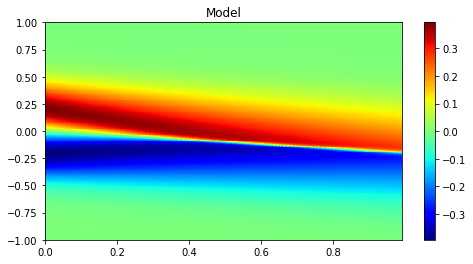

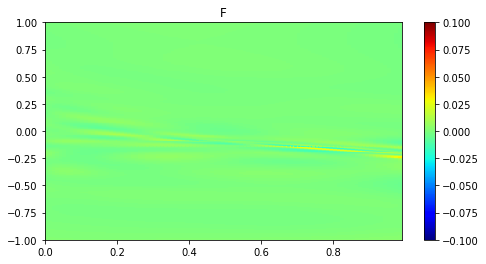

In [30]:
plt.figure(figsize=(8,4))
plt.pcolor(T, X, U_pred,cmap='jet')
plt.colorbar()
plt.title('Model')


plt.figure(figsize=(8,4))
plt.pcolor(T, X, F_pred,cmap='jet', vmin=-.1,vmax=.1)
plt.colorbar()
plt.title('F')



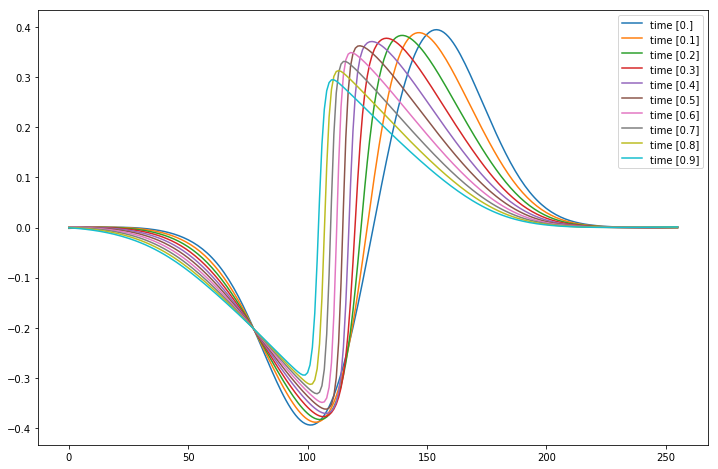

In [31]:
plt.figure(figsize=(12,8))
for tmp_i in range(0,t.shape[0],10):
    tmp_t = t[tmp_i]
    tmp_x_t = np.concatenate((x,np.full(x.shape,tmp_t)),1)
    tmp_u_pred, _ = model.predict(tmp_x_t)
    
    plt.plot(tmp_u_pred,label='time {}'.format(tmp_t))
    #plt.plot(Exact[tmp_i,:],':')
plt.legend()
    
# plt.figure(figsize=(12,8))
# for tmp_i in range(0,t.shape[0],10):
#     tmp_t = t[tmp_i]
#     tmp_u_pred = U_pred[tmp_i,:]
#     plt.plot(tmp_u_pred-Exact[0,:],label='t=%f' % tmp_t)
# plt.legend()


In [32]:
X_star_new = np.concatenate([X_star,X_star,X_star])
X_star_new[25600:,1]=X_star_new[25600:,1]+1
X_star_new[51200:,1]=X_star_new[51200:,1]+1

In [33]:
u_pred_new, f_pred_new = model.predict(X_star_new)
U_pred_new = np.reshape(u_pred_new,(len(t)*3,len(x)))


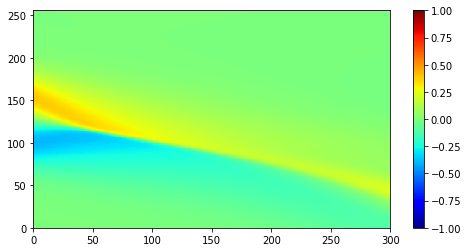

In [34]:
plt.figure(figsize=(8,4))
plt.pcolor(U_pred_new.T,cmap='jet', vmin=-1,vmax=1)
plt.colorbar()